In [ ]:
!pip -q install torch torchvision torchaudio \
transformers sentence-transformers scikit-learn \
pandas numpy tqdm matplotlib joblib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
BASE_DIR   = "/content/drive/MyDrive/FakeNewsDetector"
DATA_DIR   = os.path.join(BASE_DIR, "data")
MODELS_DIR = os.path.join(BASE_DIR, "models", "embeddings")
FIGS_DIR   = os.path.join(BASE_DIR, "figs")

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIGS_DIR, exist_ok=True)

print("Paths ready")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Paths ready


In [ ]:
import pandas as pd, json, numpy as np

# Reload your dataset (same 4 CSVs as before)
P_FK = os.path.join(DATA_DIR, "PolitiFact_fake_news_content.csv")
P_RL = os.path.join(DATA_DIR, "PolitiFact_real_news_content.csv")
G_FK = os.path.join(DATA_DIR, "BuzzFeed_fake_news_content.csv")
G_RL = os.path.join(DATA_DIR, "BuzzFeed_real_news_content.csv")

df_fake = pd.concat([pd.read_csv(P_FK), pd.read_csv(G_FK)], ignore_index=True)
df_real = pd.concat([pd.read_csv(P_RL), pd.read_csv(G_RL)], ignore_index=True)
df_fake["label"], df_real["label"] = 0, 1
df = pd.concat([df_fake, df_real], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
text_col = "content" if "content" in df.columns else "text"

# Stratified split (70/10/20)
from sklearn.model_selection import train_test_split
X = df[text_col];  y = df["label"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test,  y_val,  y_test  = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42)
print(f"Train {len(X_train)}  Val {len(X_val)}  Test {len(X_test)}")


Train 295  Val 85  Test 42


In [ ]:
embedding_models = {
    "MiniLM": "sentence-transformers/all-MiniLM-L6-v2",
    "MPNet":  "sentence-transformers/all-mpnet-base-v2",
    "E5":     "intfloat/e5-base-v2"
}


In [ ]:
# ⚡ Cell 5 — Generate and cache embeddings (safe version for Colab GPU)

import os, gc, torch, numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# Use only small/medium encoders to avoid CUDA OOM
embedding_models = {
    "MiniLM": "sentence-transformers/all-MiniLM-L6-v2",
    "MPNet":  "sentence-transformers/all-mpnet-base-v2",
    "E5":     "intfloat/e5-base-v2"
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

def embed_texts(texts, model_name, batch_size=16):
    """
    Compute sentence embeddings safely in small batches.
    """
    print(f"Loading model: {model_name}")
    model = SentenceTransformer(model_name, device=device)
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc=model_name.split('/')[-1]):
        batch = texts.iloc[i:i+batch_size].tolist()
        emb = model.encode(batch,
                           convert_to_numpy=True,
                           show_progress_bar=False,
                           normalize_embeddings=False)
        embeddings.append(emb)
    # Free memory
    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return np.vstack(embeddings)

# --- Generate and save embeddings ---
for tag, model_id in embedding_models.items():
    print(f"\n Encoding with {tag} → {model_id}")
    Xtr = embed_texts(X_train, model_id)
    Xval_ = embed_texts(X_val, model_id)
    Xte = embed_texts(X_test, model_id)

    np.save(os.path.join(DATA_DIR, f"Xtr_{tag}.npy"),  Xtr)
    np.save(os.path.join(DATA_DIR, f"Xval_{tag}.npy"), Xval_)
    np.save(os.path.join(DATA_DIR, f"Xte_{tag}.npy"),  Xte)

    print(f" Saved embeddings for {tag}:",
          Xtr.shape, Xval_.shape, Xte.shape)
    print("-"*60)

# Save labels (only once)
np.save(os.path.join(DATA_DIR, "y_train.npy"), y_train)
np.save(os.path.join(DATA_DIR, "y_val.npy"),   y_val)
np.save(os.path.join(DATA_DIR, "y_test.npy"),  y_test)

print(" All embeddings saved to:", DATA_DIR)


Using device: cuda

 Encoding with MiniLM → sentence-transformers/all-MiniLM-L6-v2
Loading model: sentence-transformers/all-MiniLM-L6-v2


all-MiniLM-L6-v2: 100%|██████████| 19/19 [00:02<00:00,  7.97it/s]


Loading model: sentence-transformers/all-MiniLM-L6-v2


all-MiniLM-L6-v2: 100%|██████████| 6/6 [00:00<00:00, 11.84it/s]


Loading model: sentence-transformers/all-MiniLM-L6-v2


all-MiniLM-L6-v2: 100%|██████████| 3/3 [00:00<00:00, 12.99it/s]


 Saved embeddings for MiniLM: (295, 384) (85, 384) (42, 384)
------------------------------------------------------------

 Encoding with MPNet → sentence-transformers/all-mpnet-base-v2
Loading model: sentence-transformers/all-mpnet-base-v2


all-mpnet-base-v2: 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]


Loading model: sentence-transformers/all-mpnet-base-v2


all-mpnet-base-v2: 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


Loading model: sentence-transformers/all-mpnet-base-v2


all-mpnet-base-v2: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


 Saved embeddings for MPNet: (295, 768) (85, 768) (42, 768)
------------------------------------------------------------

 Encoding with E5 → intfloat/e5-base-v2
Loading model: intfloat/e5-base-v2


e5-base-v2: 100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


Loading model: intfloat/e5-base-v2


e5-base-v2: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Loading model: intfloat/e5-base-v2


e5-base-v2: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


 Saved embeddings for E5: (295, 768) (85, 768) (42, 768)
------------------------------------------------------------
 All embeddings saved to: /content/drive/MyDrive/FakeNewsDetector/data


In [ ]:
# 🧩 Cell 6 — Train Logistic Regression + MLP heads on frozen embeddings

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import pandas as pd, joblib, matplotlib.pyplot as plt

# Load labels once
y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(DATA_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(DATA_DIR, "y_test.npy"))

def evaluate(y_true, y_pred, y_proba):
    """Return key metrics."""
    return {
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "roc_auc":  roc_auc_score(y_true, y_proba),
        "pr_auc":   average_precision_score(y_true, y_proba)
    }

results = []

for tag in ["MiniLM", "MPNet", "E5"]:
    print(f"\n Training classifier heads for {tag}")

    # Load cached embeddings
    Xtr = np.load(os.path.join(DATA_DIR, f"Xtr_{tag}.npy"))
    Xval = np.load(os.path.join(DATA_DIR, f"Xval_{tag}.npy"))

    # ---------- Logistic Regression ----------
    lr = LogisticRegression(max_iter=200, class_weight="balanced", n_jobs=-1)
    lr.fit(Xtr, y_train)

    y_pred = lr.predict(Xval)
    y_proba = lr.predict_proba(Xval)[:, 1]
    m = evaluate(y_val, y_pred, y_proba)
    m["model"] = f"{tag}_LogReg"
    results.append(m)
    joblib.dump(lr, os.path.join(MODELS_DIR, f"{tag}_logreg.joblib"))

    # ---------- MLP Head ----------
    mlp = MLPClassifier(hidden_layer_sizes=(512, 256),
                        activation="relu",
                        max_iter=20,
                        learning_rate_init=1e-3)
    mlp.fit(Xtr, y_train)

    y_pred = mlp.predict(Xval)
    y_proba = mlp.predict_proba(Xval)[:, 1]
    m = evaluate(y_val, y_pred, y_proba)
    m["model"] = f"{tag}_MLP"
    results.append(m)
    joblib.dump(mlp, os.path.join(MODELS_DIR, f"{tag}_mlp.joblib"))

# ----- Leaderboard -----
df_res = pd.DataFrame(results).sort_values("macro_f1", ascending=False)
df_res.to_csv(os.path.join(MODELS_DIR, "leaderboard_val_embeddings.csv"), index=False)
display(df_res)



🔸 Training classifier heads for MiniLM


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



🔸 Training classifier heads for MPNet


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



🔸 Training classifier heads for E5


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


,macro_f1,roc_auc,pr_auc,model
0,0.551389,0.526855,0.515002,MiniLM_LogReg
4,0.531846,0.565061,0.545366,E5_LogReg
5,0.514286,0.535161,0.521212,E5_MLP
2,0.491584,0.505814,0.522167,MPNet_LogReg
1,0.459822,0.470930,0.459713,MiniLM_MLP
3,0.418377,0.415282,0.477171,MPNet_MLP


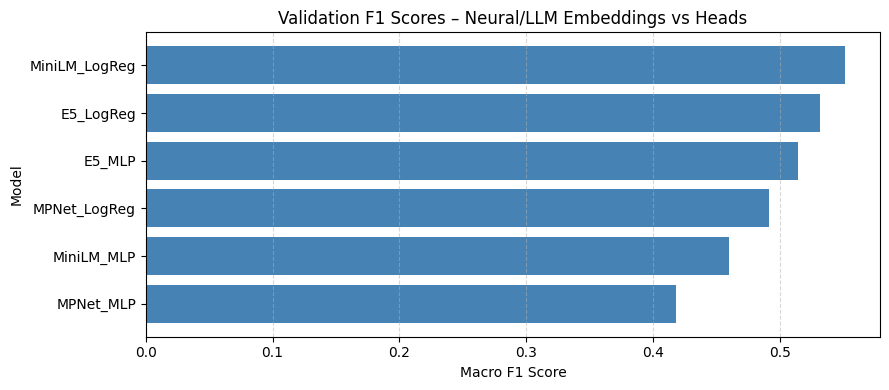

In [ ]:
plt.figure(figsize=(9,4))
plt.barh(df_res["model"], df_res["macro_f1"], color="steelblue")
plt.xlabel("Macro F1 Score")
plt.ylabel("Model")
plt.title("Validation F1 Scores – Neural/LLM Embeddings vs Heads")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "embedding_heads_leaderboard.png"))
plt.show()
